In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from xhistogram.xarray import histogram
import glob, sys
from decimal import Decimal
from eofs.xarray import Eof
sys.path.append('/home/ysilvy/bin_TS/')
from bin_functions import bin_TS
from eof_functions import compute_eof, proj_on_eof

In [2]:
plt.style.use('ggplot')

### Make the ensemble mean from dedrifted data

In [3]:
# -- Read historical members
datadir = '/data/ysilvy/bin_TS/'
V1 = xr.open_dataset(datadir+'volumeTS_dedrifted_global_0.02_0.2_IPSL-CM5A-LR_historical-rcp85_r1i1p1_1850-2100.nc').histogram_so_thetao
V2 = xr.open_dataset(datadir+'volumeTS_dedrifted_global_0.02_0.2_IPSL-CM5A-LR_historical-rcp85_r2i1p1_1850-2100.nc').histogram_so_thetao
V3 = xr.open_dataset(datadir+'volumeTS_dedrifted_global_0.02_0.2_IPSL-CM5A-LR_historical-rcp85_r3i1p1_1850-2100.nc').histogram_so_thetao
V4 = xr.open_dataset(datadir+'volumeTS_dedrifted_global_0.02_0.2_IPSL-CM5A-LR_historical-rcp85_r4i1p1_1850-2100.nc').histogram_so_thetao

In [4]:
# -- Compute ensemble mean
Vmean = (V1+V2+V3+V4)/4

In [5]:
# -- Compute anomalies relative to 1960-2017 and keep only data to 2017 (same as EN4)
Vmean_ano = Vmean.sel(time=slice(1850,2017)) - Vmean.sel(time=slice(1960,2017)).mean(dim='time')
# -- Reduce array
Vmean_red = Vmean_ano/Vmean.std(dim='time')
# -- Replace nans with zeros
Vmean_red = xr.where(np.isnan(Vmean_red)==False,Vmean_red,0)

### Fingerprint  = leading EOF

In [6]:
# -- Perform EOF 
solver=Eof(Vmean_red.stack(z=('so_bin','thetao_bin')))
pcs = solver.pcs()
eofs = solver.eofs()
var1 = solver.varianceFraction()[0].data*100
eof1 = eofs[0,:].unstack('z')

### Project historical field onto the fingerprint

In [7]:
def red_zeros(V):
    # Anomaly (center)
    V_ano = V.sel(time=slice(1960,2017)) - V.sel(time=slice(1960,2017)).mean(dim='time')
    # Reduce
    V_red = V_ano/V.std(dim='time')
    # Replace nans with zeros
    V_red = xr.where(np.isnan(V_red)==False,V_red,0)
    return V_red

In [8]:
# V1_ano = V1.sel(time=slice(1960,2017)) - V1.sel(time=slice(1960,2017)).mean(dim='time')
# V2_ano = V2.sel(time=slice(1960,2017)) - V2.sel(time=slice(1960,2017)).mean(dim='time')
# V3_ano = V3.sel(time=slice(1960,2017)) - V3.sel(time=slice(1960,2017)).mean(dim='time')
# V4_ano = V4.sel(time=slice(1960,2017)) - V4.sel(time=slice(1960,2017)).mean(dim='time')
V1_red = red_zeros(V1)
V2_red = red_zeros(V2)
V3_red = red_zeros(V3)
V4_red = red_zeros(V4)
Z1 = solver.projectField(V1_red.stack(z=('so_bin', 'thetao_bin')),neofs=1)
Z2 = solver.projectField(V2_red.stack(z=('so_bin', 'thetao_bin')),neofs=1)
Z3 = solver.projectField(V3_red.stack(z=('so_bin', 'thetao_bin')),neofs=1)
Z4 = solver.projectField(V4_red.stack(z=('so_bin', 'thetao_bin')),neofs=1)

### Project EN4 

In [9]:
# -- Read EN4
VEN4 = xr.open_dataset(datadir+'volumeTS_global_0.02_0.2_EN4_1950-2017.nc').histogram_so_thetao
# -- Make anomaly
VEN4_ano = VEN4.sel(time=slice('1960','2017')) - VEN4.sel(time=slice('1960','2017')).mean(dim='time')
# -- Reduce
VEN4_red = VEN4_ano/VEN4.std(dim='time')
# -- Replace nans with zeros
VEN4_red = xr.where(np.isnan(VEN4_red)==False,VEN4_red,0)
# -- Project EN4 on leading EOF
ZEN4 = solver.projectField(VEN4_red.stack(z=('so_bin', 'thetao_bin')),neofs=1)

### Plot

Text(0.5, 1.0, 'PC1')

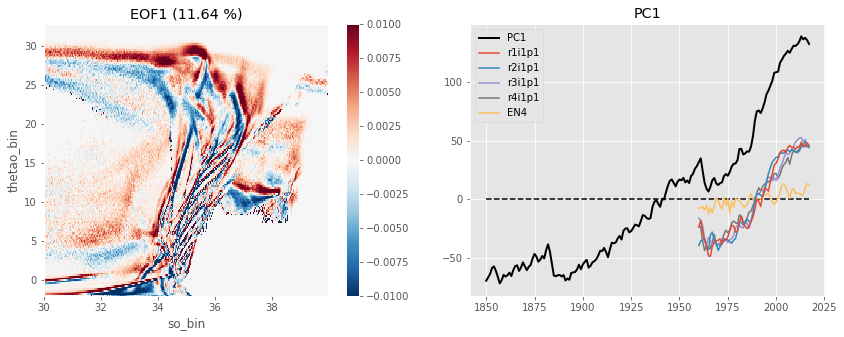

In [10]:
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(14,5))

time = np.arange(1850,2018)
timeproj = np.arange(1960,2018)


vmin = -0.01 
vmax = 0.01 

c = eof1.T.plot(ax=ax[0],add_colorbar=False,vmin=vmin,vmax=vmax,center=0,cmap='RdBu_r')
cb = fig.colorbar(c,ax=ax[0],label='')
ax[0].set_title('EOF1 ('+'%.2f '% Decimal(str(var1))+'%)')
ax[1].plot(time,pcs[:,0],label='PC1',lw=2,color='black',zorder=10)
ax[1].plot(timeproj,Z1,label='r1i1p1',zorder=9)
ax[1].plot(timeproj,Z2,label='r2i1p1',zorder=8)
ax[1].plot(timeproj,Z3,label='r3i1p1',zorder=7)
ax[1].plot(timeproj,Z4,label='r4i1p1',zorder=6)
ax[1].plot(timeproj,ZEN4,label='EN4')
ax[1].legend()
ax[1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[1].set_title('PC1')

### Project piControl

In [11]:
# -- Read dedrifted data
VpiC = xr.open_dataset(datadir+'volumeTS_dedrifted_global_0.02_0.2_IPSL-CM5A-LR_piControl_1800-2799.nc').histogram_so_thetao

In [12]:
# -- Make anomaly
VpiC_ano = VpiC - VpiC.mean(dim='time')
# -- Reduce
VpiC_red = VpiC_ano/VpiC.std(dim='time')
# -- Replace nans with zeros
VpiC_red = xr.where(np.isnan(VpiC_red)==False,VpiC_red,0)

In [13]:
# -- Project on leading EOF
N = solver.projectField(VpiC_red.stack(z=('so_bin', 'thetao_bin')),neofs=1)

### Detection

#### Start with 10 years 1960-1969

In [14]:
# -- Noise: find all possible non-overlapping 10-year segments, compute trend
i=1800
Ntrends = []
while i<2800:
    N_sub = N.sel(time=slice(i,i+9))
    model = np.polyfit(N_sub.time, N_sub, 1)
    Ntrends.append(model[0])
    i=i+10
Ntrends = np.array(Ntrends).squeeze()

In [15]:
# -- Trend in the historical members
S1 = np.polyfit(Z1.sel(time=slice(1960,1969)).time, Z1.sel(time=slice(1960,1969)), 1)[0]
S2 = np.polyfit(Z2.sel(time=slice(1960,1969)).time, Z2.sel(time=slice(1960,1969)), 1)[0]
S3 = np.polyfit(Z3.sel(time=slice(1960,1969)).time, Z3.sel(time=slice(1960,1969)), 1)[0]
S4 = np.polyfit(Z4.sel(time=slice(1960,1969)).time, Z4.sel(time=slice(1960,1969)), 1)[0]

In [16]:
# -- Trend in EN4
SEN4 = np.polyfit(np.arange(1960,1970), ZEN4.sel(time=slice('1960','1969')), 1)[0]

Text(0.5, 1.0, 'L=10 years')

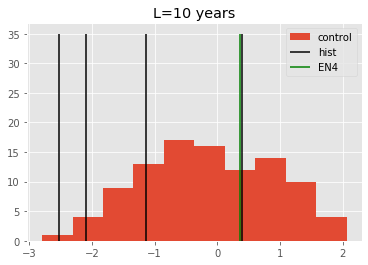

In [17]:
plt.hist(Ntrends,label='control')
plt.vlines(S1,ymin=0,ymax=35,label='hist')
plt.vlines(S2,ymin=0,ymax=35)
plt.vlines(S3,ymin=0,ymax=35)
plt.vlines(S4,ymin=0,ymax=35)
plt.vlines(SEN4,ymin=0,ymax=35,label='EN4',color='green')
plt.legend()
plt.title('L=10 years')

#### Compare with 1960-2017

In [18]:
# -- Noise: find all possible non-overlapping 58-year segments, compute trend
i=1800
Ntrends = []
while i<2800:
    N_sub = N.sel(time=slice(i,i+57))
    model = np.polyfit(N_sub.time, N_sub, 1)
    Ntrends.append(model[0])
    i=i+58
Ntrends = np.array(Ntrends).squeeze()

In [19]:
# -- Trend in the historical members
S1 = np.polyfit(Z1.time, Z1, 1)[0]
S2 = np.polyfit(Z2.time, Z2, 1)[0]
S3 = np.polyfit(Z3.time, Z3, 1)[0]
S4 = np.polyfit(Z4.time, Z4, 1)[0]

In [20]:
# -- Trend in EN4
SEN4 = np.polyfit(np.arange(1960,2018), ZEN4, 1)[0]

Text(0.5, 1.0, 'L=58 years')

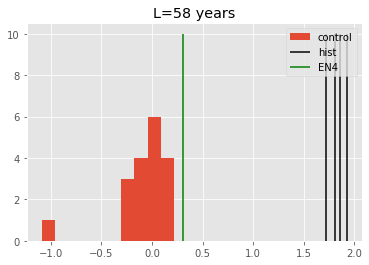

In [22]:
plt.hist(Ntrends,label='control')
plt.vlines(S1,ymin=0,ymax=10,label='hist')
plt.vlines(S2,ymin=0,ymax=10)
plt.vlines(S3,ymin=0,ymax=10)
plt.vlines(S4,ymin=0,ymax=10)
plt.vlines(SEN4,ymin=0,ymax=10,label='EN4',color='green')
plt.legend()
plt.title('L=58 years')

In [23]:
sigma = Ntrends.std()

In [24]:
SNR1 = S1/sigma
SNR2 = S2/sigma
SNR3 = S3/sigma
SNR4 = S4/sigma
SNREN4 = SEN4/sigma

In [25]:
SNR1,SNR2,SNR3,SNR4,SNREN4

(array([6.785744]),
 array([7.01977824]),
 array([6.59580489]),
 array([6.27770434]),
 array([1.13711313]))

#### Loop on L

In [26]:
# -- Define signal arrays
S1 = np.zeros(49)*np.nan
S2 = np.zeros(49)*np.nan
S3 = np.zeros(49)*np.nan
S4 = np.zeros(49)*np.nan
SEN4 = np.zeros(49)*np.nan
# -- Define noise array
sigma = np.zeros(49)*np.nan
# -- Define signal to noise ratios
SNR1 = np.zeros(49)*np.nan
SNR2 = np.zeros(49)*np.nan
SNR3 = np.zeros(49)*np.nan
SNR4 = np.zeros(49)*np.nan
SNREN4 = np.zeros(49)*np.nan

In [27]:
for L in range(10,59):
    # -- Noise: find all possible non-overlapping L-year segments, compute trends and std of distribution
    i=1800
    Ntrends = []
    while i<2800:
        N_sub = N.sel(time=slice(i,i+L-1))
        model = np.polyfit(N_sub.time, N_sub, 1) # m,p
        Ntrends.append(model[0])
        i=i+L
    Ntrends = np.array(Ntrends).squeeze()
    sigma[L-10] = np.std(Ntrends)
    
    # -- Trend in the historical members
    S1[L-10] = np.polyfit(Z1.sel(time=slice(1960,1960+L-1)).time, Z1.sel(time=slice(1960,1960+L-1)), 1)[0]
    S2[L-10] = np.polyfit(Z2.sel(time=slice(1960,1960+L-1)).time, Z2.sel(time=slice(1960,1960+L-1)), 1)[0]
    S3[L-10] = np.polyfit(Z3.sel(time=slice(1960,1960+L-1)).time, Z3.sel(time=slice(1960,1960+L-1)), 1)[0]
    S4[L-10] = np.polyfit(Z4.sel(time=slice(1960,1960+L-1)).time, Z4.sel(time=slice(1960,1960+L-1)), 1)[0]

    # -- Trend EN4
    SEN4[L-10] = np.polyfit(np.arange(1960,1960+L), ZEN4.sel(time=slice('1960',str(1960+L-1))), 1)[0]


/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3296: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3296: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


In [28]:
# -- Signal to noise ratios
SNR1 = S1/sigma
SNR2 = S2/sigma
SNR3 = S3/sigma
SNR4 = S4/sigma
SNREN4 = SEN4/sigma

Text(0.5, 0, 'Last year of trend')

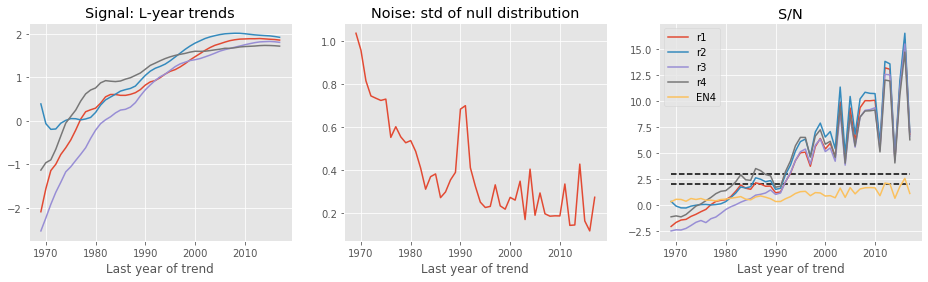

In [29]:
fig,ax = plt.subplots(ncols=3,figsize=(16,4))

# Signal
ax[0].plot(np.arange(1969,2018),S1)
ax[0].plot(np.arange(1969,2018),S2)
ax[0].plot(np.arange(1969,2018),S3)
ax[0].plot(np.arange(1969,2018),S4)
ax[0].set_title('Signal: L-year trends')
ax[0].set_xlabel('Last year of trend')

# Noise
ax[1].plot(np.arange(1969,2018),sigma)
ax[1].set_title('Noise: std of null distribution')
ax[1].set_xlabel('Last year of trend')

# S/N
ax[2].plot(np.arange(1969,2018),SNR1,label='r1')
ax[2].plot(np.arange(1969,2018),SNR2,label='r2')
ax[2].plot(np.arange(1969,2018),SNR3,label='r3')
ax[2].plot(np.arange(1969,2018),SNR4,label='r4')
ax[2].plot(np.arange(1969,2018),SNREN4,label='EN4')
ax[2].hlines(2,xmin=1969,xmax=2017,ls='--')
ax[2].hlines(3,xmin=1969,xmax=2017,ls='--')
ax[2].legend()
ax[2].set_title('S/N')
ax[2].set_xlabel('Last year of trend')

# plt.savefig('maquette_CM5_reduced.png')